In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.optim as optim
from torchvision.datasets import ImageFolder

# Data exploration

In [108]:
def unpack_data(filename):
    with open(filename, mode='rb') as f:
        file = pickle.load(f)
    return file['features'], file['labels']

In [109]:
X_train, y_train = unpack_data("Data/Preprocessed/train.p")
X_valid, y_valid = unpack_data("Data/Preprocessed/valid.p")
X_test, y_test = unpack_data("Data/Preprocessed/test.p")

In [110]:
print("Number of training examples =", X_train.shape[0])
print("Number of validation examples =", X_valid.shape[0])
print("Number of testing examples =", X_test.shape[0])
print("Image data shape =", X_train[0].shape)
print("Number of classes =", len(set(y_train)))

Number of training examples = 97660
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


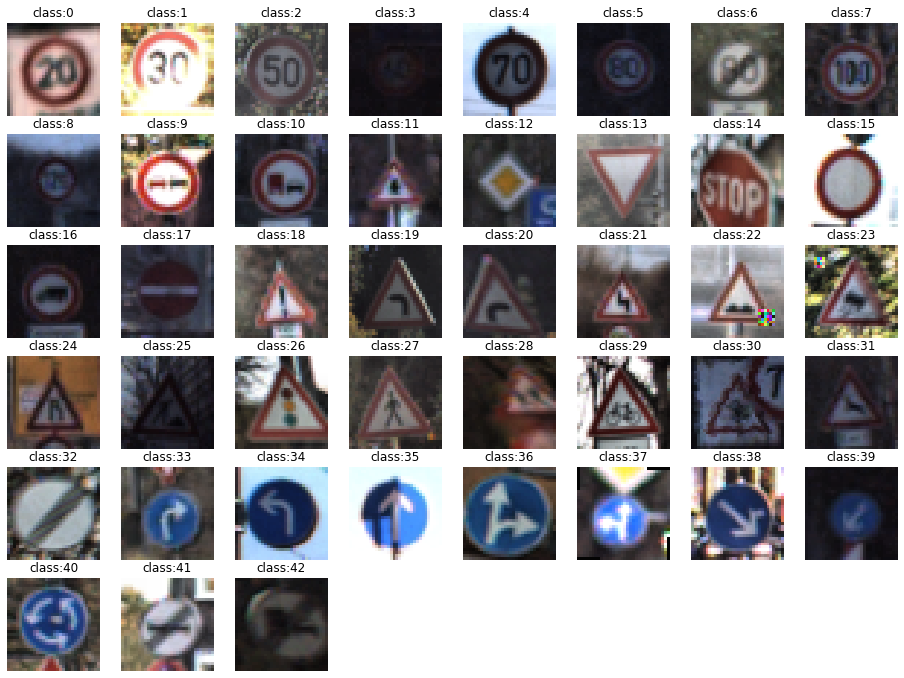

In [111]:
plt.figure(figsize=(16, 16))
for c in range(len(set(y_train))):
    i = np.random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class:'+str(c))
    plt.imshow(X_train[i])

In [112]:
class ImageDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        return (self.X[index], self.y[index])

    def __len__(self):
        return len(self.y)
    
    
def class_weights(y):
    count = 1/np.bincount(y)
    weights = count/(np.sum(count))
    weights = (weights - weights.min()) / (weights.max() - weights.min())+1
    return weights

In [113]:
train_dataset = ImageDataset(np.moveaxis(X_train, -1, 1), y_train)
valid_dataset = ImageDataset(np.moveaxis(X_valid, -1, 1), y_valid)
test_dataset = ImageDataset(np.moveaxis(X_test, -1, 1), y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [114]:
import torch.nn as nn
import torch.nn.functional as F


class BaslineNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.fc1 = nn.Linear(800, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 43)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [115]:
def evaluate(model, criterion, dl):
    loss = 0
    accuracy = 0
    num_examples = len(dl.dataset)
    model.eval()
    with torch.no_grad():
        for batch in dl:
            inputs, labels = batch[0].float().to('cuda:0'),batch[1].long().to('cuda:0')
            output = model(inputs)
            loss += criterion(output, labels)
            predictions = torch.argmax(output, dim=1)
            accuracy += torch.sum(predictions == labels)
        accuracy = accuracy.item()
        loss = loss.item()
        accuracy = accuracy/num_examples
        loss = loss/num_examples
    return loss, accuracy

In [116]:
def train_network(model, criterion, optimizer, epochs = 10):
    global_acc = 0
    for epoch in range(epochs):
        running_loss = 0.0
        accuracy = 0.0
        for i, batch in enumerate(train_loader):
            inputs, labels = batch[0].float().to('cuda:0'),batch[1].long().to('cuda:0')

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            accuracy += torch.sum(predictions == labels)

        print("----------------------- Epoch  {} -----------------".format(epoch))
        train_loss, train_acc = running_loss/len(y_train), accuracy/len(y_train)
        print("Train loss: {} Train accuracy: {}".format(train_loss, train_acc))
        valid_loss, valid_acc = evaluate(model, criterion, valid_loader)
        print("Valid loss: {} Valid accuracy: {}".format(valid_loss, valid_acc))
        if valid_acc > global_acc:
            global_acc = valid_acc
            torch.save(model.state_dict(), 'best-model-parameters.pt')

    print('-------------------- Finished Training --------------------')
    model.load_state_dict(torch.load('best-model-parameters.pt'))
    test_loss, test_acc = evaluate(model, criterion, test_loader)
    print("Test loss: {} Test accuracy: {}".format(test_loss, test_acc))

In [117]:
#Initialize model
baseline = BaslineNN().to('cuda:0')

# Initialize optimizer and criterion
adam = optim.Adam(baseline.parameters(), lr=0.001)

# Initialize criterion
weights = torch.cuda.FloatTensor(class_weights(y_train))
criterion = nn.CrossEntropyLoss(weights)

In [118]:
train_network(baseline, criterion, adam)

----------------------- Epoch  0 -----------------
Train loss: 0.01588095849043835 Train accuracy: 0.749037504196167
Valid loss: 0.0086437813549085 Valid accuracy: 0.8442176870748299
----------------------- Epoch  1 -----------------
Train loss: 0.006745804618405509 Train accuracy: 0.8889514803886414
Valid loss: 0.005437604424093856 Valid accuracy: 0.8956916099773242
----------------------- Epoch  2 -----------------
Train loss: 0.0051882546893815915 Train accuracy: 0.9127380847930908
Valid loss: 0.005028105322736191 Valid accuracy: 0.9192743764172335
----------------------- Epoch  3 -----------------
Train loss: 0.004320682797652671 Train accuracy: 0.925312340259552
Valid loss: 0.004540120338907047 Valid accuracy: 0.9165532879818594
----------------------- Epoch  4 -----------------
Train loss: 0.003853732069507783 Train accuracy: 0.9346405863761902
Valid loss: 0.004487834766067886 Valid accuracy: 0.9222222222222223
----------------------- Epoch  5 -----------------
Train loss: 0.0033

# Sharpness-Aware Minimization

In [119]:
from sam import SAM

In [120]:
def train_network_sam(model, criterion, optimizer, epochs = 10):
    global_acc = 0
    for epoch in range(epochs):
        running_loss = 0.0
        accuracy = 0.0
        for i, batch in enumerate(train_loader):
            inputs, labels = batch[0].float().to('cuda:0'),batch[1].long().to('cuda:0')

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # first forward-backward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.first_step(zero_grad=True)

            # second forward-backward pass
            outputs = model(inputs)
            criterion(outputs, labels).backward()
            optimizer.second_step(zero_grad=True)

            # print statistics
            running_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            accuracy += torch.sum(predictions == labels)

        print("----------------------- Epoch  {} -----------------".format(epoch))
        train_loss, train_acc = running_loss/len(train_loader.dataset), accuracy/len(train_loader.dataset)
        print("Train loss: {} Train accuracy: {}".format(train_loss, train_acc))
        valid_loss, valid_acc = evaluate(model, criterion, valid_loader)
        print("Valid loss: {} Valid accuracy: {}".format(valid_loss, valid_acc))
        if valid_acc > global_acc:
            global_acc = valid_acc
            torch.save(model.state_dict(), 'best-model-parameters.pt')
    print('-------------------- Finished Training --------------------')
    model.load_state_dict(torch.load('best-model-parameters.pt'))
    test_loss, test_acc = evaluate(model, criterion, test_loader)
    print("Test loss: {} Test accuracy: {}".format(test_loss, test_acc))

In [121]:
#Initialize model
baseline = BaslineNN().to('cuda:0')

# Initialize optimizer and criterion
base_optimizer = torch.optim.Adam
optimizer = SAM(baseline.parameters(), base_optimizer, lr=0.001, rho=0.01)

# Initialize criterion
weights = torch.cuda.FloatTensor(class_weights(y_train))
criterion = nn.CrossEntropyLoss(weights)

In [122]:
train_network_sam(baseline, criterion, optimizer, 5)

----------------------- Epoch  0 -----------------
Train loss: 0.012651111128332428 Train accuracy: 0.775732159614563
Valid loss: 0.004448069358358578 Valid accuracy: 0.9213151927437642
----------------------- Epoch  1 -----------------
Train loss: 0.004449524923574661 Train accuracy: 0.9116834402084351
Valid loss: 0.0036898961142888143 Valid accuracy: 0.936281179138322
----------------------- Epoch  2 -----------------
Train loss: 0.003239915435229217 Train accuracy: 0.9314253926277161
Valid loss: 0.003493882523102014 Valid accuracy: 0.9426303854875283
----------------------- Epoch  3 -----------------
Train loss: 0.0027788731368955134 Train accuracy: 0.9412144422531128
Valid loss: 0.003057668863240283 Valid accuracy: 0.9503401360544218
----------------------- Epoch  4 -----------------
Train loss: 0.0024603636339234356 Train accuracy: 0.9457915425300598
Valid loss: 0.00336782191616067 Valid accuracy: 0.9482993197278912
-------------------- Finished Training --------------------
Test 

# Stronger model

In [123]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 48, 5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(48, 64, 5)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(512, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 43)
        self.dropout = nn.Dropout(p=0.5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [124]:
#Initialize model
traffic_model = TrafficSignNet().to('cuda:0')

# Initialize optimizer and criterion
base_optimizer = torch.optim.Adam
optimizer = SAM(traffic_model.parameters(), base_optimizer, lr=0.001, rho=0.05)

# Initialize criterion
count = 1/np.bincount(y_train)
weights = torch.cuda.FloatTensor(count/(np.sum(count)))
criterion = nn.CrossEntropyLoss(weights)

In [125]:
train_network_sam(traffic_model, criterion, optimizer, 20)

----------------------- Epoch  0 -----------------
Train loss: 0.01741520120057932 Train accuracy: 0.6961294412612915
Valid loss: 0.002428712001463183 Valid accuracy: 0.9628117913832199
----------------------- Epoch  1 -----------------
Train loss: 0.001850242231085251 Train accuracy: 0.9524575471878052
Valid loss: 0.0013164918168602077 Valid accuracy: 0.97437641723356
----------------------- Epoch  2 -----------------
Train loss: 0.0008032000175612488 Train accuracy: 0.9719025492668152
Valid loss: 0.0018304083082411025 Valid accuracy: 0.972562358276644
----------------------- Epoch  3 -----------------
Train loss: 0.0005020027795622881 Train accuracy: 0.9782716035842896
Valid loss: 0.0020126165446240343 Valid accuracy: 0.9673469387755103
----------------------- Epoch  4 -----------------
Train loss: 0.00034710330442749696 Train accuracy: 0.9824903011322021
Valid loss: 0.0014775938998544567 Valid accuracy: 0.980498866213152
----------------------- Epoch  5 -----------------
Train loss:

In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_class_freq(i, counts):
    counts = counts/np.sum(counts)
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 5.5)
    ax.bar(range(len(counts)), counts, 0.5, color='r')
    ax.set_xlabel('Signs')
    ax.set_xticks(np.arange(len(counts)))
    ax.set_ylabel('Count')
    ax.set_title('The count of each sign for class '+str(i))
    plt.show()

def plot_confusion_matrix(dataset, model):
    model.eval()
    with torch.no_grad():
        inputs, labels = torch.FloatTensor(dataset.X),torch.LongTensor(dataset.y)
        outputs = model(inputs)
    predictions = torch.argmax(outputs, dim=1)
    matrix = confusion_matrix(labels, predictions)
    for i, row in enumerate(matrix):
        plot_class_freq(i, row)

In [ ]:
model = TrafficSignNet()
model.load_state_dict(torch.load('best-model-parameters.pt'))
plot_confusion_matrix(test_dataset, model)